In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import itertools
import time

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%pwd

'/content'

In [7]:
data = pd.read_csv('data/character-predictions_pose.csv')
# data = pd.read_csv('../character-predictions_pose.csv')
def clean(characters):
    # selected columns I think might be relevant
    characters = characters.loc[:,['name', 'male', 'house', 'isNoble', 'numDeadRelations', 'popularity', 'isAlive', 'culture', 'boolDeadRelations', 'isPopular']]
    # deleted all observations that have NaNs
    characters = characters[~characters.isnull().any(axis=1)]
    characters.reset_index(inplace = True, drop = True)
    
    # clean cultures 

    culture_counts = pd.DataFrame(characters.culture.value_counts())

    #combining culture names that mean the same thing 
    characters.culture = characters.culture.replace(to_replace = "northmen", value = "Northmen")
    characters.culture = characters.culture.replace(to_replace = "ironborn", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Ironmen", value = "Ironborn")
    characters.culture = characters.culture.replace(to_replace = "Asshai'i", value = "Asshai")
    characters.culture = characters.culture.replace(to_replace = "Free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "free folk", value = "Free Folk")
    characters.culture = characters.culture.replace(to_replace = "Summer Islands", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "Summer Islander", value = "Summer Isles")
    characters.culture = characters.culture.replace(to_replace = "westermen", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerman", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Westerlands", value = "Westermen")
    characters.culture = characters.culture.replace(to_replace = "Vale", value = "Valemen")
    characters.culture = characters.culture.replace(to_replace = "Lhazareen", value = "Lhazarene")
    characters.culture = characters.culture.replace(to_replace = "The Reach", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Reachmen", value = "Reach")
    characters.culture = characters.culture.replace(to_replace = "Qarth", value = "Qartheen")
    characters.culture = characters.culture.replace(to_replace = "Lyseni", value = "Lysene")
    characters.culture = characters.culture.replace(to_replace = "Stormlander", value = "Stormlands")
    characters.culture = characters.culture.replace(to_replace = "Meereenese", value = "Meereen")
    characters.culture = characters.culture.replace(to_replace = "Astapor", value = "Astapori")
    characters.culture = characters.culture.replace(to_replace = "Norvos", value = "Norvoshi")
    characters.culture = characters.culture.replace(to_replace = "Wildlings", value = "Wildling")
    characters.culture = characters.culture.replace(to_replace = "Andals", value = "Andal")
    characters.culture = characters.culture.replace(to_replace = "Braavos", value = "Braavosi")
    characters.culture = characters.culture.replace(to_replace = "Dorne", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Dornishmen", value = "Dornish")
    characters.culture = characters.culture.replace(to_replace = "Ghiscaricari", value = "Ghiscari")

    #getting survival rates per culture 
    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    survival_counts = pd.DataFrame(characters.groupby(['culture']).isAlive.value_counts())
    survival_counts.rename({'isAlive':'count_survived'}, axis='columns', inplace=True)
    survival_counts = pd.DataFrame(survival_counts.to_records())
    #for Qohor and Astapori, no one survived — this will be taken into account later and for now they will be dropped
    survival_counts = survival_counts[survival_counts['isAlive'] == 1] 
    survival_counts.drop(columns=["isAlive"], inplace=True)
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "total"})
    survival_df = culture_counts.merge(survival_counts)
    survival_df['percent_survived'] = (survival_df['count_survived']/survival_df['total'])*100
    survival_df = survival_df.sort_values(by=['percent_survived'], ascending=False)

    #grouping cultures based on their survival rates
    characters.culture = characters.culture.replace(to_replace = ['Ibbenese', 'Asshai', 'Lhazarene', 'Summer Isles', 'First Men', 'Naathi', 'Norvoshi', 'Rhoynar', 'Crannogmen'], value = "all_survive")
    characters.culture = characters.culture.replace(to_replace = ['Ironborn', 'Ghiscari', 'Vale mountain clans', 'Dornish', 'Reach'], value = "most_survive")
    characters.culture = characters.culture.replace(to_replace = ['Dothraki', 'Stormlands', 'Rivermen', 'Braavosi', 'Northmen'], value = "many_survive")
    characters.culture = characters.culture.replace(to_replace = ['Qartheen', 'Myrish', 'Lysene', 'Valemen', 'Northern mountain clans', 'Tyroshi', 'Westeros'], value = "morethanhalf_survive")
    characters.culture = characters.culture.replace(to_replace = ['Westermen', 'Riverlands', 'Pentoshi', 'Free Folk', 'Sistermen', 'Meereen'], value = "half_survive")
    characters.culture = characters.culture.replace(to_replace = ['Riverlands', 'Lysene', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Wildling', 'Valyrian'], value = "few_survive")
    characters.culture = characters.culture.replace(to_replace = ['Astapori', 'Qohor'], value = "none_survive")



    culture_counts = pd.DataFrame(characters.culture.value_counts()).reset_index()
    culture_counts = culture_counts.rename(columns={'index':'culture', "culture" : "count"})
    display(culture_counts)
    
    
    for house in characters.house:

        percent_alive = characters[characters.house == house].isAlive.mean()

        characters.loc[characters.house == house, 'house_alive'] = percent_alive



    # Bin house_alive into 5 bins

    binned_house_alive = pd.qcut(characters['house_alive'],10,retbins=True, duplicates = 'drop')

    bins = binned_house_alive[1]

    characters['house_alive_binned'] = pd.cut(characters['house_alive'],bins = bins)

    dum = pd.get_dummies(characters.house_alive_binned,drop_first = True)

    dum.columns = ['house_alive'+str(x) for x in range(1,len(bins)-1)]

    characters = pd.concat([characters,dum], axis = 1)

 

    age_data = characters.groupby('house_alive_binned')['isAlive'].agg([('percent','mean'),('nobs','count')]).reset_index(drop=False)

    # sns.lineplot(x = age_data.index, y= age_data['percent'])

    # plt.xlabel('house_bin')
    
    return characters
characters = clean(data)

,culture,count
0,most_survive,186
1,many_survive,167
2,morethanhalf_survive,49
3,few_survive,44
4,half_survive,29
5,all_survive,15
6,none_survive,3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
def bin_opp(num):
    return 1 if num==0 else 0

In [9]:
def test_person(name, formula, data = characters):
    train = data.loc[data['name'] != name]
    person = data.loc[data['name'] == name]
    model = sm.logit(formula = formula, data=data).fit(disp=0)
    prediction = model.predict(person)
    return prediction.values[0], person["isAlive"].values[0]

In [10]:
def test(formula, num_examples=50, loss_func=None, cutoff=.3, clean_data=characters):
    accurate_counter = 0
    mat_state = [[0,0],[0,0]]
    for index, row in clean_data.iterrows():
        p, act = test_person(row['name'], formula, data = clean_data)
        if p + cutoff >= 1:
            bin_p = 1
        else:
            bin_p = 0
        mat_state[bin_opp(bin_p)][bin_opp(act)] += 1
        if index >= num_examples:
            break
    if loss_func is None:
        return mat_state[0][0]+mat_state[1][1], mat_state
    else:
        return loss_func(accurate_counter), mat_state

In [29]:
characters

,name,male,house,isNoble,numDeadRelations,popularity,isAlive,culture,boolDeadRelations,isPopular,house_alive,house_alive_binned,house_alive1,house_alive2,house_alive3,house_alive4,house_alive5,house_alive6,house_alive7
0,Walder Frey,1,House Frey,1,1,0.896321,1,many_survive,1,1,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
1,Sylva Santagar,0,House Santagar,1,0,0.043478,1,most_survive,0,0,0.500000,"(0.31, 0.5]",1,0,0,0,0,0,0
2,Valarr Targaryen,1,House Targaryen,1,0,0.431438,0,few_survive,0,1,0.309524,"(0.0, 0.31]",0,0,0,0,0,0,0
3,Will Humble,1,House Humble,0,0,0.013378,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
4,Wulfe,1,House Greyjoy,0,0,0.023411,1,most_survive,0,0,0.785714,"(0.75, 0.833]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Tarle,1,Drowned men,0,0,0.026756,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
489,Gormond Goodbrother,1,House Goodbrother,0,0,0.040134,1,most_survive,0,0,1.000000,"(0.87, 1.0]",0,0,0,0,0,0,1
490,Walder Rivers,1,House Frey,1,0,0.080268,1,many_survive,0,0,0.857143,"(0.833, 0.87]",0,0,0,0,0,1,0
491,Laena Velaryon,0,House Velaryon,0,0,0.140468,0,few_survive,0,0,0.222222,"(0.0, 0.31]",0,0,0,0,0,0,0


In [37]:
X = characters[['male', 'house_alive_binned', 'isNoble', 'numDeadRelations', 'popularity', 'culture', 'boolDeadRelations', 'isPopular']]
Xy = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["house"])
X = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])

In [34]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('isAlive~' + '+'.join(predictor_subset))
    model = sm.logit('isAlive~' + '+'.join(predictor_subset),data = Xy).fit()
    accuracy = test(formula = 'isAlive~' + '+'.join(predictor_subset), num_examples = len(characters), cutoff=.5, clean_data=Xy)[0]
    accuracy /= len(characters)
    return {"model":model, "accuracy":accuracy}

In [35]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [38]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["accuracy", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

isAlive~numDeadRelations
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
isAlive~popularity
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
isAlive~house_alive
Optimization terminated successfully.
         Current function value: 0.412677
         Iterations 6
isAlive~house_alive_binned
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
isAlive~house_alive1
Optimization terminated successfully.
         Current function value: 0.594923
         Iterations 5
isAlive~house_alive2
Optimization terminated successfully.
         Current function value: 0.610506
         Iterations 5
isAlive~house_alive3
Optimization terminated successfully.
         Current function value: 0.610998
         Iterations 5
isAlive~house_alive4
Optimization terminated successfully.
         Current function value: 0.610881
         Iterations 5
isAlive~h

KeyboardInterrupt: ignored

In [25]:
sm.logit(formula="isAlive~male_0", data=Xy).fit()

Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5


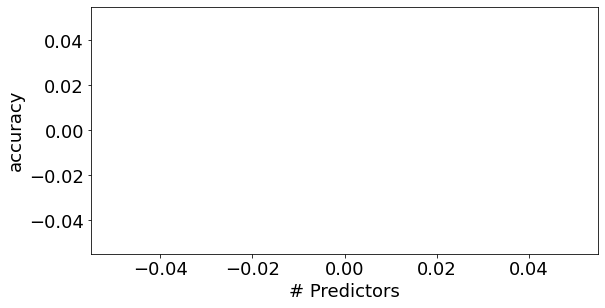

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('accuracy')

best_sub_plots()

In [40]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [42]:
#Filtering all predictors
X = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])
y = characters["isAlive"]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

alphas = 10**np.linspace(0,-2.5,200)*0.5

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

#Note that we are reducing the range of alpha so as to better visualize the minimum
# alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 100, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
# pred1=lasso.predict(Xtest1_std)
pd.Series(lasso.coef_, X.columns)

numDeadRelations                    -0.000000
popularity                           0.000000
house_alive                          0.236170
house_alive1                        -0.000000
house_alive2                        -0.000000
house_alive3                        -0.000000
house_alive4                        -0.000000
house_alive5                         0.000000
house_alive6                         0.000000
house_alive7                         0.000000
male_0                               0.010957
male_1                              -0.000000
house_alive_binned_(0.0, 0.31]       0.000000
house_alive_binned_(0.31, 0.5]      -0.000000
house_alive_binned_(0.5, 0.571]     -0.000000
house_alive_binned_(0.571, 0.717]   -0.000000
house_alive_binned_(0.717, 0.75]    -0.000000
house_alive_binned_(0.75, 0.833]     0.000000
house_alive_binned_(0.833, 0.87]     0.000000
house_alive_binned_(0.87, 1.0]       0.000000
isNoble_0                           -0.000000
isNoble_1                         

In [ ]:
from sklearn.linear_model import LogisticRegression

X = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])
X_backup = pd.get_dummies(characters, columns=["male","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])
    
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print(models)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()
best_sub_plots()

isAlive~numDeadRelations
Optimization terminated successfully.
         Current function value: 0.601337
         Iterations 5
isAlive~popularity
Optimization terminated successfully.
         Current function value: 0.609617
         Iterations 5
isAlive~house_alive
Optimization terminated successfully.
         Current function value: 0.412677
         Iterations 6
isAlive~house_alive_binned
Optimization terminated successfully.
         Current function value: 0.416256
         Iterations 9
isAlive~house_alive1
Optimization terminated successfully.
         Current function value: 0.594923
         Iterations 5
isAlive~house_alive2
Optimization terminated successfully.
         Current function value: 0.610506
         Iterations 5
isAlive~house_alive3
Optimization terminated successfully.
         Current function value: 0.610998
         Iterations 5
isAlive~house_alive4
Optimization terminated successfully.
         Current function value: 0.610881
         Iterations 5
isAlive~h

In [ ]:
from sklearn.linear_model import LogisticRegression

characters["Intercept"] = 1
X = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])
X_backup = pd.get_dummies(characters, columns=["male","house_alive_binned","isNoble","culture","boolDeadRelations","isPopular"]).drop(columns=["name","house","isAlive"])

def forward_model_selection(df):

    # Create a list of all features except the target variable
    features = X

    # Create an empty list to store the selected features
    selected_features = []

    # Create a baseline model with only the intercept
    # model = LogisticRegression().fit(df[['Intercept']], df["isAlive"])

    # Calculate the baseline score
    baseline_score, throwaway = test(formula="isAlive~1", clean_data=characters, num_examples=500, cutoff=.5)

    # Loop over the features and select the best one at each iteration
    while not features.empty:
        best_score = -1
        best_feature = None

        # Loop over the remaining features and find the one with the highest score
        for feature in features:
            
            formula = "isAlive~" + "+".join(selected_features) + "+" + feature

            # Calculate the score for the new model
            score, throwaway = test(formula=formula, clean_data=characters, num_examples=500, cutoff=.5)

            # If the score is better than the previous best score, update the best score and feature
            if score > best_score:
                best_score = score
                best_feature = feature

        # Add the best feature to the selected features list and remove it from the features list
        selected_features.append(best_feature)
        print(selected_features)
        features.drop(columns=best_feature)

        # If the new score is worse than the baseline score, stop the selection process
        if best_score <= baseline_score:
            break
            
        baseline_score = best_score

    return selected_features

forward_model_selection(characters)

KeyboardInterrupt: ignored